In [1]:
#Importing modules, tools, etc.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics import regressionplots

#importing main dataframe as df
df = pd.read_csv('data/kc_house_data.csv')

### Data Cleaning

In [2]:
#Converting grade column to an int value

#Create a dummy list
grade_num = []

#Go through each row, grabbing the first index off the string, conver to int
for index, row in df.iterrows():
    grade_num.append(int((str(row['grade'])[0:2])))

#drop the old column and add the new
df['grade_num'] = grade_num
df.drop('grade', axis = 1);

Converting the grade to a numeric value.  For the sake of consistency, it was descided to keep the scale provided by the city, however, we will later process this data into categorical data.

In [3]:
# Turning NaNs in the waterfront data into NO's, then converting waterfront to binary.
# 0 is a waterfront no, 1 is a waterfront yes
#

df.waterfront.fillna(value='NO', inplace = True)
df.waterfront.replace( to_replace = ['NO','YES'], value =  [0,1], inplace = True)

A quick check on a random sample of the NaN's within the waterfront column via the lat/long provided showed that these properties were not on the waterfront. It was decided that we'd fill in the Nan's as nos.

12764    13540
7245     12050
3910     10040
9245      9890
8085      9640
         ...  
11488      420
8614       410
21316      390
860        380
15367      370
Name: sqft_living, Length: 21597, dtype: int64
4980.0


<AxesSubplot:ylabel='Frequency'>

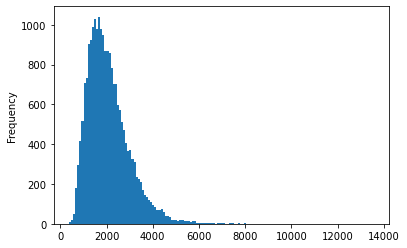

In [4]:
print(df['sqft_living'].sort_values(ascending = False))
#Those are some big results.
print(df['sqft_living'].quantile(0.99))
# even the 99 percentile is still sub 5000. 
binvar = np.sqrt(df.sqft_living.count())
df['sqft_living'].plot(kind = 'hist', bins = int(binvar))
#Plotting this shows a bit skew right.

#It may be wise to shave the model off around there.

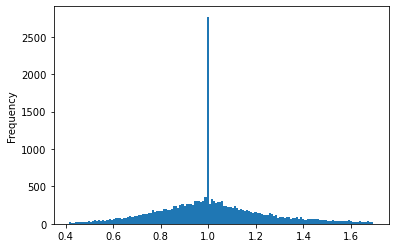

In [5]:
df.sqft_living.describe()
df['sqft_living_ratio'] = df['sqft_living'] / df['sqft_living15']
df.sqft_living_ratio.describe()

df['sqft_living_ratio'] = df.sqft_living / df.sqft_living15
df['sqft_living_ratio'] = df['sqft_living_ratio'].loc[(np.abs(stats.zscore(df.sqft_living_ratio)) < 2)]
df = df.dropna(subset = ['sqft_living_ratio'])
df.sqft_living_ratio.plot(kind = 'hist', bins = int(binvar));

1717     1651359
17305    1164794
7640     1074218
3945      982998
4437      982278
          ...   
21536        638
20588        635
3449         609
7582         600
5821         572
Name: sqft_lot, Length: 20621, dtype: int64
206478.8


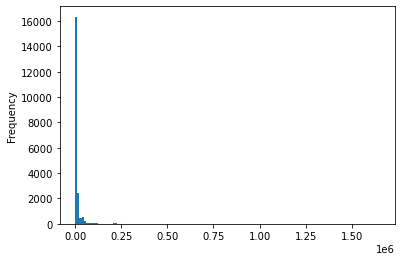

In [6]:
print(df['sqft_lot'].sort_values(ascending = False)) 
#Holy cow! I don't think those are residential sales.
print(df['sqft_lot'].quantile(0.99))
#99th quantile, still high, still well below those outliers

df['sqft_lot'].plot(kind = 'hist', bins = int(binvar));
#Some weirdness at the far end

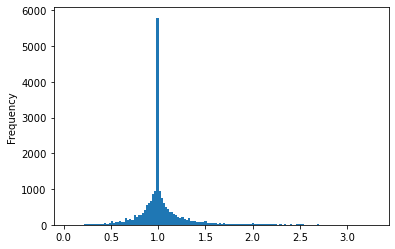

In [7]:
df.sqft_lot15.describe()
df['sqft_lot_ratio'] = df['sqft_lot'] / df['sqft_lot15']
df.sqft_lot_ratio.describe()

df['sqft_lot_ratio'] = df.sqft_lot / df.sqft_lot15
df['sqft_lot_ratio'] = df['sqft_lot_ratio'].loc[(np.abs(stats.zscore(df.sqft_lot_ratio)) < 2)]
df = df.dropna(subset = ['sqft_lot_ratio'])
df.sqft_lot_ratio.plot(kind = 'hist', bins = int(binvar));

The data exploration above showed some outliers. The 'sqft_~_ratio' variables were created to weed out outliers. In effect, if a lot size or living sq ft size was too different from the neighboring property, then it was deemed an outlier. Dropping outliers this way allowed us to, e.g. keep a large mansion in a neighborhood of large mansions.

In [8]:
df.bedrooms.value_counts()
bedstandev = np.std(df.bedrooms)
#outliter threshold is often set at 3 std devs
upper_bound = df.bedrooms.mean() + bedstandev * 3
df= df[df.bedrooms <= upper_bound]

In [9]:
df.bedrooms.value_counts()


3    9520
4    6426
2    2662
5    1379
6     198
1     166
Name: bedrooms, dtype: int64

One house had wildely more bedrooms than any other, and was cut as an outlier. This is a weird one because eventually we're going to make bedrooms an ordinal categorical dataset. But, to put some rigour in the outlier reduction process, went ahead and did a 3x standard dev test anyway.

In [10]:
df['view'] = df['view'].replace({'NONE': 0, 'AVERAGE': 1, 'GOOD': 2, 'FAIR': 3, 'EXCELLENT':4}).fillna(0)

As with grade, we will later process this into categorical data.

In [11]:
df['floors'].value_counts()
#Seems reasonable. 

1.0    10231
2.0     7653
1.5     1752
3.0      575
2.5      134
3.5        6
Name: floors, dtype: int64

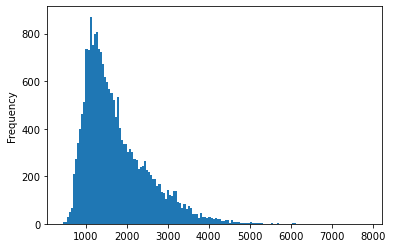

In [12]:
#cleaning the square feet above ground data
df['sqft_above'].sort_values(ascending = False)
#Not quite as extreme as sqft_livable

df['sqft_above'].plot(kind = 'hist', bins = int(binvar));

In [13]:
#cleaning the basement data
df['sqft_basement'] = df['sqft_basement'].replace({'?': 0.0})
df['sqft_basement'] = df['sqft_basement'].astype(float)

Lacking other information, it was decided to assume that unknown basement square footage would be captured in sqft_livable and ? was set to 0. 

Now that the data has been given a preliminary cleaning, a correlation heatmap was generated.


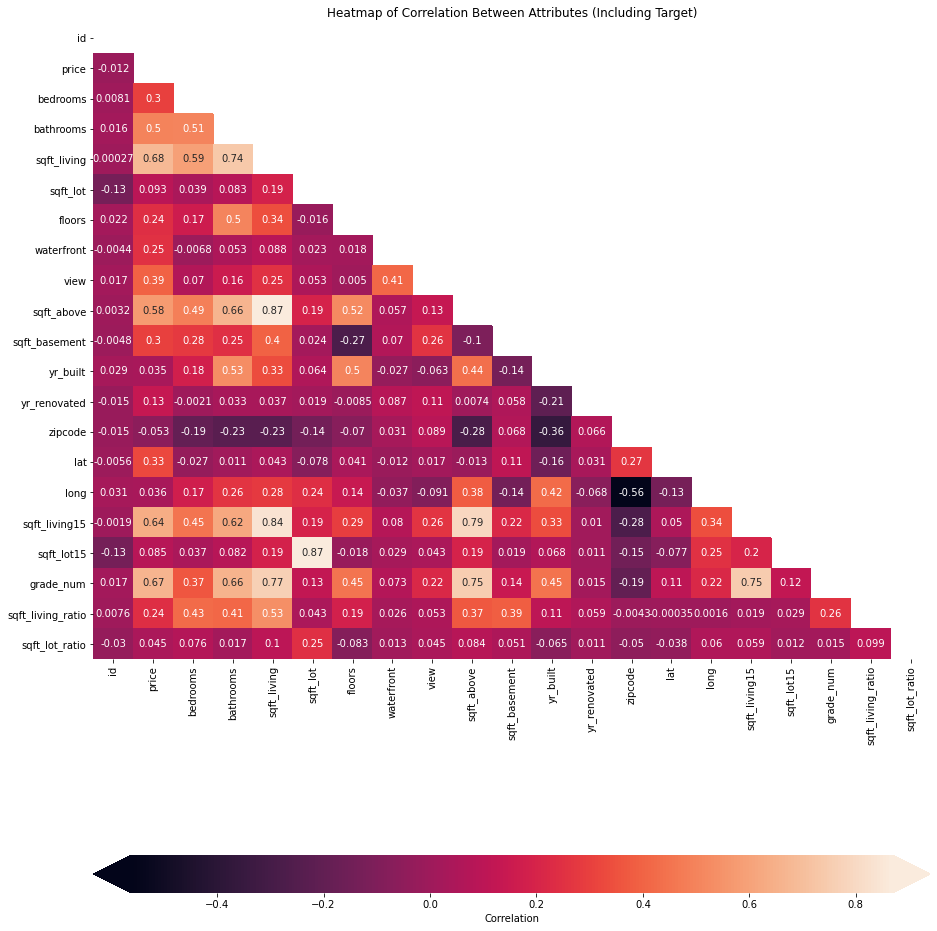

In [14]:
import seaborn as sns
import numpy as np

corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 18))
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [15]:
ohe = OneHotEncoder(sparse = False)
ohe.fit_transform(df[['zipcode']])
zip_encoded = ohe.fit_transform(df[['zipcode']])
zip_enc_df = pd.DataFrame(zip_encoded, columns=ohe.categories_[0], index=df.index)
df_original = pd.concat([df, zip_enc_df], axis=1)
ziplist = ohe.categories_[0].tolist()
zipliststr = []
for i in ziplist: 
    zipliststr.append(str(i))

In [16]:
ord_enc = OrdinalEncoder()
ord_enc_f_t = ord_enc.fit_transform(df[['bedrooms','bathrooms','floors','grade_num']])
ord_enc_df = pd.DataFrame(ord_enc_f_t, columns = ['bedrooms_cat','bathrooms_cat','floors_cat','grade_num_cat'], index=df.index)

df_ord = pd.concat([df_original, ord_enc_df], axis=1)


df_ord

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,98168,98177,98178,98188,98198,98199,bedrooms_cat,bathrooms_cat,floors_cat,grade_num_cat
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,3.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,2.0,3.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,10.0,0.0,3.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.0,4.0
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,16.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,4.0,4.0
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,2.0,4.0
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,2.0,4.0


This cell encodes the zipcode data, and creates a variable of strings to use as column names later.

Additionally, it processes a number of variables (bedrooms, bathrooms, floors and grade) into ordinal categorical data. 

With this, basic preprocessing is done.

### Spliting the data into testing and training sets

In [17]:
X = df_original.drop(columns = ['id','date','price','lat','long','sqft_living_ratio','sqft_lot_ratio','condition','yr_built','yr_renovated','grade','zipcode'])

### The baseline model

The baseline model we chose to use was a simple model using the information we grabbed from the correlation heatmap, namely that price's highest correlated variable was livable square feet.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,df.price)

training_data = pd.concat([X_train,y_train], axis = 1)
testing_data = pd.concat([X_test,y_test], axis = 1)

from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()

from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=training_data[['sqft_living']],
    y=training_data.price,
    return_train_score=True,
    cv=splitter
)


baseline_model.fit(X_train,y_train)

baseline_pred_train = baseline_model.predict(X_train)
baseline_pred_test = baseline_model.predict(X_test)

baseline_train_residuals = baseline_pred_train - y_train
baseline_test_residuals = baseline_pred_test - y_test

print("Baseline Train score:     ", baseline_scores["train_score"].mean())
print("Baseline Validation score:", baseline_scores["test_score"].mean())

baseline_ols = ols('price ~ sqft_living', data = training_data).fit()

ols('price ~ sqft_living', data = training_data).fit().summary()

Baseline Train score:      0.46874942612999
Baseline Validation score: 0.4548179158456815


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                 1.329e+04
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:25:33   Log-Likelihood:            -2.1069e+05
No. Observations:               15263   AIC:                         4.214e+05
Df Residuals:                   15261   BIC:                         4.214e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9976.5037   5009.553     -1.991      0.046   -1.98e+04    -157.181
sqft_living   263.9065      2.289    115.277      0.000     259.419     268.394
==============================================================================
Omnibus:                     8465.461   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           129809.154
Skew:                           2.338   Prob(JB):                         0.00
Kurtosis:                      16.500   Cond. No.                     5.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Copy this cell over

As we can see, the R-squared score isn't great. Additionally, our training score is higher than the validation score by a fair bit, indicating underfitting. 

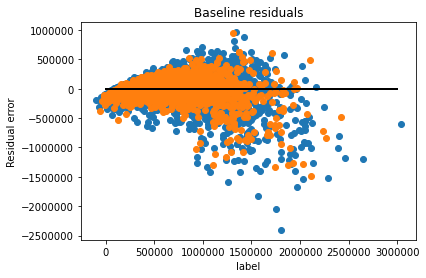

In [19]:
plt.title('Baseline residuals')
plt.scatter(baseline_pred_train, baseline_train_residuals)
plt.scatter(baseline_pred_test, baseline_test_residuals)

plt.plot([0, 3000000], [0, 0], color='k', linestyle='-', linewidth=2)
plt.xlabel('label')
### What should I label this?!? Ask David/Skylar in check in.
plt.ylabel('Residual error')
plt.ticklabel_format(style='plain')

# Copy this cell over!


The above chart shows the residual errors of our baseline model. Clearly it violates the homoskedastiticity assumption, becoming less accurate with a bias developing towards missing high.    

In [20]:
size_bed_bath = LinearRegression()

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=training_data[['sqft_living','bedrooms','bathrooms']],
    y=training_data.price,
    return_train_score=True,
    cv=splitter
)

print("Size Bedroom Bathroom Train score:", baseline_scores["train_score"].mean())
print("Size Bedroom Bathroom Test score: ", baseline_scores["test_score"].mean())


Size Bedroom Bathroom Train score: 0.48325330917496934
Size Bedroom Bathroom Test score:  0.467752205326891


In [21]:
size_bed_bath_quality = LinearRegression()

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=training_data[['sqft_living','bedrooms','bathrooms','grade_num']],
    y=training_data.price,
    return_train_score=True,
    cv=splitter
)

print("Size Bedroom Bathroom Grade Train score:", baseline_scores["train_score"].mean())
print("Size Bedroom Bathroom Grade Test score: ", baseline_scores["test_score"].mean())


Size Bedroom Bathroom Grade Train score: 0.5292899947823811
Size Bedroom Bathroom Grade Test score:  0.5139224668387669


Second Model Train score:      0.8109075301256435
Second Model Validation score: 0.8011962618087457


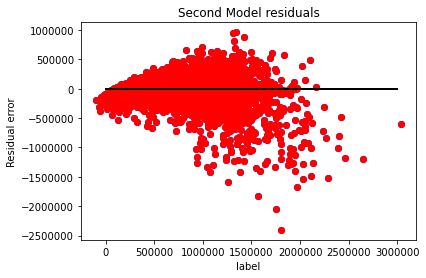

In [22]:
second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=training_data.drop(columns = 'price'),
    y=y_train,
    return_train_score=True,
    cv=splitter
)


second_model.fit(X_train,y_train)

second_model_pred_train = second_model.predict(X_train)
second_model_pred_test = second_model.predict(X_test)

second_model_train_residuals = second_model_pred_train - y_train
second_model_test_residuals = second_model_pred_test - y_test



print("Second Model Train score:     ", second_model_scores["train_score"].mean())
print("Second Model Validation score:", second_model_scores["test_score"].mean())






plt.title('Second Model residuals')
plt.plot([0, 3000000], [0, 0], color='k', linestyle='-', linewidth=2)

plt.scatter(baseline_pred_train, baseline_train_residuals, color = 'blue')
plt.scatter(baseline_pred_test, baseline_test_residuals, color = 'blue')
plt.scatter(second_model_pred_train, second_model_train_residuals, color = 'red' )
plt.scatter(second_model_pred_test, second_model_test_residuals, color = 'red')

plt.ticklabel_format(style='plain')
plt.xlabel('label')
### What should I label this?!? Ask David/Skylar in check in.
plt.ylabel('Residual error');



In [23]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

X_train_for_RFECV = StandardScaler().fit_transform(X_train)
model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)

RFECV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.25, train_size=None),
      estimator=LinearRegression())

In [24]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train,y_train)
print(linreg.score(X_train, y_train))
print(linreg.score(X_test, y_test))
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

from sklearn.metrics import mean_squared_error

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

# Calculate training and test MSE

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Root Mean Squarred Error:', np.sqrt(train_mse))
print('Test Root Mean Squarred Error:', np.sqrt(test_mse))

0.8090934659100797
0.8240653063173322
Train Root Mean Squarred Error: 142954.14146078142
Test Root Mean Squarred Error: 140816.91482139032


In [25]:
final_train = ols('y_train ~ X_train', data = training_data).fit()
#final_train.summary()

In [26]:
final_test = ols('y_test ~ X_test', testing_data).fit()
#final_test.summary()

In [27]:
Seattle_zipcodes = [98101, 98102, 98103, 98104, 98105, 
                    98106, 98107, 98108, 98109, 98112, 
                    98115, 98116, 98117, 98118, 98119, 
                    98121, 98122, 98125, 98126, 98133, 
                    98134, 98136, 98144, 98146, 98154, 
                    98164, 98174, 98177, 98178, 98195, 
                    98199 ]

df['in_Seattle'] = np.where(df['zipcode'].isin(Seattle_zipcodes),1,0)


In [28]:
X = df.drop(columns = ['id','date','price','lat','long','sqft_living_ratio','sqft_lot_ratio','condition','yr_built','yr_renovated','grade','zipcode'])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,df.price)

training_data = pd.concat([X_train,y_train], axis = 1)
testing_data = pd.concat([X_test,y_test], axis = 1)

In [30]:
baseline_scores = cross_validate(
    estimator=baseline_model,
    X=training_data[['sqft_living']],
    y=training_data.price,
    return_train_score=True,
    cv=splitter
)

print("Baseline Train score:     ", baseline_scores["train_score"].mean())
print("Baseline Validation score:", baseline_scores["test_score"].mean())

Baseline Train score:      0.46747564431429667
Baseline Validation score: 0.47181432100718407


In [31]:
size_bed_bath = LinearRegression()

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=training_data[['sqft_living','bedrooms','bathrooms']],
    y=training_data.price,
    return_train_score=True,
    cv=splitter
)

print("Size Bedroom Bathroom Train score:", baseline_scores["train_score"].mean())
print("Size Bedroom Bathroom Test score: ", baseline_scores["test_score"].mean())

Size Bedroom Bathroom Train score: 0.4820305642454676
Size Bedroom Bathroom Test score:  0.48955045856882345


In [32]:
size_bed_bath_quality = LinearRegression()

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=training_data[['sqft_living','bedrooms','bathrooms','grade_num']],
    y=training_data.price,
    return_train_score=True,
    cv=splitter
)

print("Size Bedroom Bathroom Grade Train score:", baseline_scores["train_score"].mean())
print("Size Bedroom Bathroom Grade Test score: ", baseline_scores["test_score"].mean())


Size Bedroom Bathroom Grade Train score: 0.5236017240549072
Size Bedroom Bathroom Grade Test score:  0.5326683370433617


In [33]:
second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=training_data.drop(columns = 'price'),
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Second Model Train score:     ", second_model_scores["train_score"].mean())
print("Second Model Validation score:", second_model_scores["test_score"].mean())

Second Model Train score:      0.6419030775574838
Second Model Validation score: 0.6414142454692876


In [34]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

X_train_for_RFECV = StandardScaler().fit_transform(X_train)
model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train)

print("Columns Selected:")
for index, col in enumerate(X_train.columns):
    print(f"{col}: {selector.support_[index]}")


Columns Selected:
bedrooms: True
bathrooms: False
sqft_living: True
sqft_lot: False
floors: True
waterfront: True
view: True
sqft_above: False
sqft_basement: False
sqft_living15: True
sqft_lot15: False
grade_num: True
in_Seattle: True


In [35]:
ols('price ~ bedrooms + sqft_living + floors + C(waterfront)+ view + sqft_living15 + sqft_lot15 + grade_num + C(in_Seattle)', data = training_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     3039.
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:25:37   Log-Likelihood:            -2.0803e+05
No. Observations:               15263   AIC:                         4.161e+05
Df Residuals:                   15253   BIC:                         4.162e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -5.541e+05   1.53e+04    -36.168      0.000   -5.84e+05   -5.24e+05
C(waterfront)[T.1]  6.399e+05   2.28e+04     28.079      0.000    5.95e+05    6.85e+05
C(in_Seattle)[T.1]  1.773e+05   3764.043     47.100      0.000     1.7e+05    1.85e+05
bedrooms           -2.238e+04   2419.431     -9.251      0.000   -2.71e+04   -1.76e+04
sqft_living          154.0971      4.322     35.658      0.000     145.626     162.568
floors             -4.977e+04   3445.652    -14.443      0.000   -5.65e+04    -4.3e+04
view                5.497e+04   2785.325     19.734      0.000    4.95e+04    6.04e+04
sqft_living15         88.5722      4.702     18.839      0.000      79.356      97.788
sqft_lot15            -0.2775      0.067     -4.127      0.000      -0.409      -0.146
grade_num           8.743e+04   2501.097     34.958      0.000    8.25e+04    9.23e+04
==============================================================================
Omnibus:                     7724.153   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120691.433
Skew:                           2.057   Prob(JB):                         0.00
Kurtosis:                      16.148   Cond. No.                     3.96e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

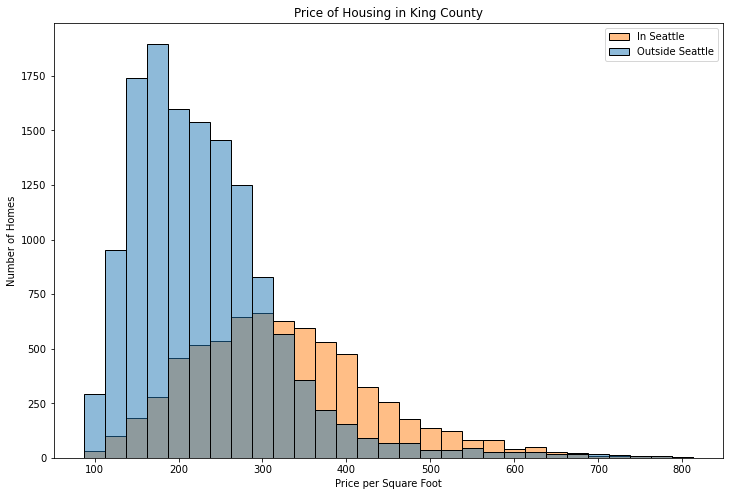

In [36]:
df['price_per_sqft'] = df['price'].div(df['sqft_living'])

fig, ax = plt.subplots(figsize = (12,8))
sns.histplot(ax=ax, data = df, x = 'price_per_sqft', hue = 'in_Seattle', binwidth = 25, alpha = .5)
ax.set_xlabel('Price per Square Foot')
ax.set_ylabel('Number of Homes')
ax.set_title('Price of Housing in King County')
ax.legend(['In Seattle','Outside Seattle']);